# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import neighbors as nh
import scikitplot as skplt
#from sklearn.metrics import top_k_accuracy_score, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit as sss

import xgboost as xgb

## 0.1 Load data

In [2]:
home_path = "/home/marcos/Documentos/comunidade_DS/pa004_health_insurance_cross_sell/"

In [3]:
df_tree_train = pd.read_pickle(home_path + "interim/df6_new_tree_train.pkl")

df_tree_validation = pd.read_pickle(home_path + "interim/df6_new_tree_val.pkl")

## 0.2 Separate train and validation data

In [4]:
df7_train = df_tree_train.copy()

df7_validation = df_tree_validation.copy()

In [5]:
df7_train.isna().sum()

vintage                 0
annual_premium          0
age                     0
region_code             0
policy_sales_channel    0
vehicle_hist            0
vehicle_damage          0
previously_insured      0
id                      0
response                0
dtype: int64

In [6]:
df7_validation.isna().sum()

vintage                 0
annual_premium          0
age                     0
region_code             0
policy_sales_channel    3
vehicle_hist            0
vehicle_damage          0
previously_insured      0
id                      0
response                0
dtype: int64

In [7]:
df7_validation.shape

(76222, 10)

I will drop the rows containing NAs from df7_validation. Since it contains over 76k rows, this must not make a big difference.

In [8]:
df7_validation.dropna(axis=0, inplace=True)
df7_validation.isna().sum()

vintage                 0
annual_premium          0
age                     0
region_code             0
policy_sales_channel    0
vehicle_hist            0
vehicle_damage          0
previously_insured      0
id                      0
response                0
dtype: int64

In [9]:
df7_validation.shape

(76219, 10)

## 0.3 Helper Functions

In [10]:
# precision_at_k
def precision_at_k(data, k):
    data = data.reset_index(drop=True)
    data['n_samples'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['n_samples']
    return data.loc[k, 'precision_at_k']

# recall_at_k
def recall_at_k(data, k):
    data = data.reset_index(drop=True)
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    return data.loc[k, 'recall_at_k']

# model predict
def model_evaluate(model, model_name, data_train, data_val, k):
    # separate X and Y data:
    xtrain = data_train.drop(['id', 'response'], axis=1)
    ytrain = data_train.response
    xval = data_val.drop(['id', 'response'], axis=1)
    yval = data_val.response
    
    # fit and predict_proba:
    model.fit(xtrain, ytrain)
    yhat_proba = model.predict_proba(xval)
    
    # transform yhat_proba to 1D-array
    yhat_proba_1d = yhat_proba[:, 1].tolist()
    
    # include in dataframe
    validation_data = data_val.copy()
    validation_data['score'] = yhat_proba_1d
    # sort
    validation_data = validation_data.sort_values('score', ascending=False)
    
    # plot
    skplt.metrics.plot_cumulative_gain(yval, yhat_proba);
    
    return pd.DataFrame({'Model name':model_name,
                         'precision_at_k':precision_at_k(validation_data, k),
                         'recall_at_k':recall_at_k(validation_data, k)}, index=[0])

# model fit
def model_fit(model, data):
    # separate X and Y data:
    xtrain = data.drop(['id', 'response'], axis=1)
    ytrain = data.response
    
    # fit
    model_fitted = model.fit(xtrain, ytrain)
    
    return model_fitted



def cross_validation(model, model_name, training_data, k_top, kfolds, verbose=False):
    # X separate X and Y data:
    xtraining = training_data.drop(['response'], axis=1)
    ytraining = training_data.response
    
    # cross-validation:
    cv = sss(n_splits=kfolds)
    prec_k_list = []
    rec_k_list = []
    for train_index, prim_val_index in cv.split(xtraining, ytraining):
        X_training, X_prim_val = xtraining.iloc[train_index], xtraining.iloc[prim_val_index]
        y_training, y_prim_val = ytraining.iloc[train_index], ytraining.iloc[prim_val_index]
        
        # remove id from training, and create new validation without id
        X_training = X_training.drop(['id'], axis=1)
        X_prim_val_no_id = X_prim_val.drop(['id'], axis=1)
        
        # fit and predict_proba
        model.fit(X_training, y_training)
        yhat_proba = model.predict_proba(X_prim_val_no_id)
        
        # transform yhat_proba to 1D-array
        yhat_proba_1d = yhat_proba[:, 1].tolist()
        
        # reconstruct dataframe
        prim_val = pd.concat([X_prim_val, y_prim_val], axis=1)
        prim_val['score'] = yhat_proba_1d
        prim_val = prim_val.sort_values('score', ascending=False)
        
        # evaluate accuracy and store in list
        prec_k_list.append(precision_at_k(prim_val, k_top))
        rec_k_list.append(recall_at_k(prim_val, k_top))
    
    #evaluate mean and std
    prec_k_pred = np.round(np.mean(prec_k_list), 4).astype(str) + '+/-' + np.round(np.std(prec_k_list), 4).astype(str)
    rec_k_pred = np.round(np.mean(rec_k_list), 4).astype(str) + '+/-' + np.round(np.std(rec_k_list), 4).astype(str)
    
    return pd.DataFrame({'Model name':model_name,
                         'precision_at_k':prec_k_pred,
                         'recall_at_k':rec_k_pred}, index=[0])

# 7.0 Machine Learning Model

## 7.1 Models

### 7.1.1 Logistic Classifier

/home/marcos/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,Model name,precision_at_k,recall_at_k
0,Logistic Regression Classifier,0.269087,0.576108


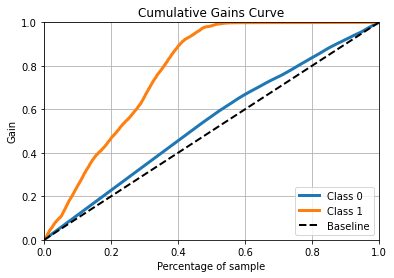

In [11]:
model_logreg = LogReg(random_state=30, solver='saga', n_jobs=-1)

logreg_ranking = model_evaluate(model_logreg, "Logistic Regression Classifier", df7_train, df7_validation, 20000)

logreg_ranking

### 7.1.2 KNN

,Model name,precision_at_k,recall_at_k
0,Nearest Neighbors Classifier,0.306735,0.656712


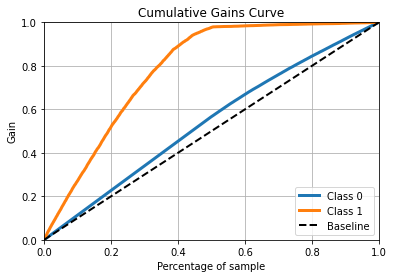

In [12]:
model_knn = nh.KNeighborsClassifier(n_neighbors=20)

knn_ranking = model_evaluate(model_knn, "Nearest Neighbors Classifier", df7_train, df7_validation, 20000)

knn_ranking

### 7.1.3 Random Forest Classifier

,Model name,precision_at_k,recall_at_k
0,Random Forest Classifier,0.329884,0.706273


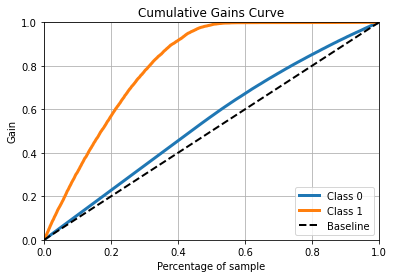

In [13]:
model_rf = RF(n_estimators=500, max_depth=10, random_state=30, n_jobs=-1)

rf_ranking = model_evaluate(model_rf, "Random Forest Classifier", df7_train, df7_validation, 20000)

rf_ranking

### 7.1.4 XGBoost Classifier

,Model name,precision_at_k,recall_at_k
0,XGBoost Classifier,0.330583,0.707771


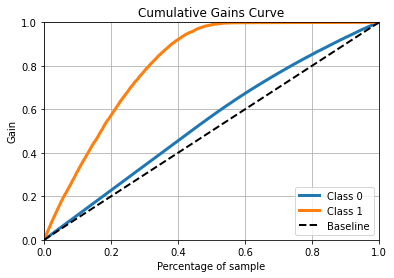

In [14]:
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              use_label_encoder=False,
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              n_jobs=-1,
                              subsample=0.7,
                              colsample_bytree=0.9,
                              verbosity=0)

xgb_ranking = model_evaluate(model_xgb, "XGBoost Classifier", df7_train, df7_validation, 20000)

xgb_ranking

## 7.2 Cross-validation

### 7.2.1 Logistic Regression

In [15]:
model_logreg = LogReg(random_state=30, solver='saga', n_jobs=-1)

logreg_cv_metrics = cross_validation(model_logreg, "Logistic Regression Classifier", df7_train, 20000, 5)

logreg_cv_metrics

/home/marcos/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/marcos/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/marcos/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/marcos/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/marcos/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_it

,Model name,precision_at_k,recall_at_k
0,Logistic Regression Classifier,0.1867+/-0.0001,0.9992+/-0.0006


### 7.2.2 KNN

In [16]:
model_knn = nh.KNeighborsClassifier(n_neighbors=50, n_jobs=-1)

knn_cv_metrics = cross_validation(model_knn, "Nearest Neighbors Classifier", df7_train, 20000, 5)

knn_cv_metrics

,Model name,precision_at_k,recall_at_k
0,Nearest Neighbors Classifier,0.186+/-0.0001,0.9954+/-0.0005


### 7.2.3 Random Forest Classifier

In [17]:
model_rf = RF(n_estimators=100, max_depth=10, random_state=30, n_jobs=-1)

rf_cv_metrics = cross_validation(model_rf, "Random Forest Classifier", df7_train, 20000, 5)

rf_cv_metrics

,Model name,precision_at_k,recall_at_k
0,Random Forest Classifier,0.1867+/-0.0,0.9992+/-0.0002


### 7.2.4 XGBoost Classifier

In [18]:
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              use_label_encoder=False,
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              n_jobs=-1,
                              subsample=0.7,
                              colsample_bytree=0.9,
                              min_child_weight=1,
                              verbosity=0)

xgb_cv_metrics = cross_validation(model_xgb, "XGBoost Classifier", df7_train, 20000, 5)

xgb_cv_metrics

,Model name,precision_at_k,recall_at_k
0,XGBoost Classifier,0.1865+/-0.0001,0.9984+/-0.0004


# 8.0 Hyperparameter Fine Tunning

## 8.1 XGBoost Classifier

In [19]:
param = {'n_estimators':[2000, 2500, 3000, 3500],
         'eta':[0.01, 0.03],
         'gamma':[3, 10, 20],
         'max_depth':[3, 5, 9],
         'subsample':[0.1, 0.5, 0.7],
         'colsample_bytree':[0.3, 0.7, 0.9],
         'min_child_weight':[3, 8, 15],
        }

MAX_EVAL = 5

In [20]:
final_result = pd.DataFrame()
hyperparam_lst = []

for i in range(MAX_EVAL):
    #randomly selected hyperparameters
    hp = {k:random.sample(v, 1)[0] for k, v in param.items()}
    #print the selected ones
    print(hp)
    #store in list
    hyperparam_lst.append(hp.copy())
    #model
    model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                  use_label_encoder=False,
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  gamma=hp['gamma'],
                                  max_depth=hp['max_depth'],
                                  n_jobs=-1,
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'],
                                  verbosity=0)
    result = cross_validation(model_xgb, 'XGBoost Classifier', df7_train, 20000, 5)
    iter_nr = pd.Series([i], name='Iter_nr')
    result_w_nr = pd.concat([result, iter_nr], axis=1)
    final_result = pd.concat([final_result, result_w_nr], ignore_index=True)

final_result.sort_values(by=['precision_at_k'], ascending=False, inplace=True, ignore_index=True)
final_result

{'n_estimators': 3500, 'eta': 0.01, 'gamma': 3, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 3000, 'eta': 0.03, 'gamma': 3, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 2000, 'eta': 0.01, 'gamma': 10, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.03, 'gamma': 20, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 2000, 'eta': 0.01, 'gamma': 10, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}


,Model name,precision_at_k,recall_at_k,Iter_nr
0,XGBoost Classifier,0.1868+/-0.0,0.9997+/-0.0002,0
1,XGBoost Classifier,0.1867+/-0.0001,0.9994+/-0.0003,4
2,XGBoost Classifier,0.1867+/-0.0,0.999+/-0.0002,1
3,XGBoost Classifier,0.1867+/-0.0,0.9993+/-0.0002,2
4,XGBoost Classifier,0.1867+/-0.0,0.9995+/-0.0002,3


In [21]:
final_result.to_pickle(home_path + 'interim/xgb_tunning_new_tree_cv.pkl')

In [22]:
# select the hyperparameters that resulted in best accuracy
best_param_nr = final_result.loc[0, 'Iter_nr']

param_tuned = hyperparam_lst[best_param_nr]

In [23]:
#model
model_xgb_tuned = xgb.XGBClassifier(objective='binary:logistic',
                                    use_label_encoder=False,
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    gamma=param_tuned['gamma'],
                                    max_depth=param_tuned['max_depth'],
                                    n_jobs=-1,
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'],
                                    verbosity=0)

,Model name,precision_at_k,recall_at_k
0,XGBoost Classifier,0.333683,0.714408


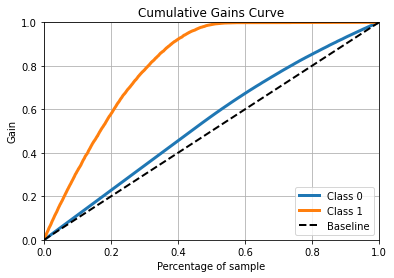

In [24]:
xgb_tuned_ranking = model_evaluate(model_xgb_tuned, "XGBoost Classifier", df7_train, df7_validation, 20000)

xgb_tuned_ranking

In [25]:
xgb_tuned = model_fit(model_xgb_tuned, df7_train)

In [26]:
pickle.dump(xgb_tuned, open(home_path + "ml_models_comp/xgb_tuned_new_tree.pkl", "wb"))

### 8.1.1 Validation

{'n_estimators': 3500, 'eta': 0.01, 'gamma': 3, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}


,Model name,precision_at_k,recall_at_k
0,XGBoost Classifier,0.333683,0.714408


{'n_estimators': 2000, 'eta': 0.01, 'gamma': 10, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}


,Model name,precision_at_k,recall_at_k
0,XGBoost Classifier,0.333083,0.713124


{'n_estimators': 3000, 'eta': 0.03, 'gamma': 3, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}


,Model name,precision_at_k,recall_at_k
0,XGBoost Classifier,0.320984,0.687219


{'n_estimators': 2000, 'eta': 0.01, 'gamma': 10, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}


,Model name,precision_at_k,recall_at_k
0,XGBoost Classifier,0.333783,0.714622


{'n_estimators': 3500, 'eta': 0.03, 'gamma': 20, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}


,Model name,precision_at_k,recall_at_k
0,XGBoost Classifier,0.332633,0.71216


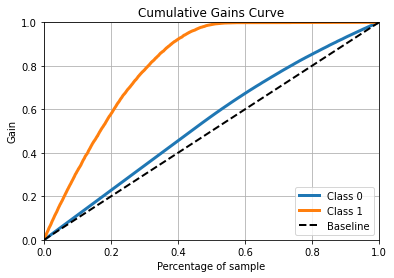

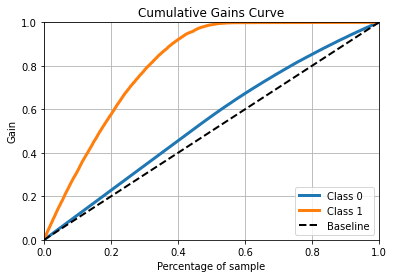

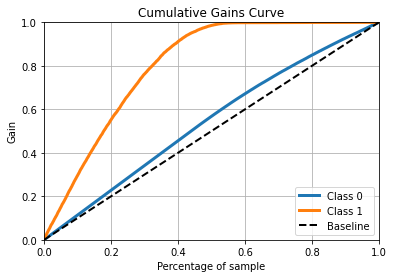

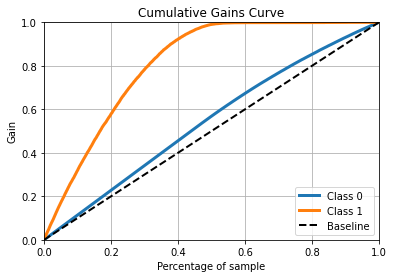

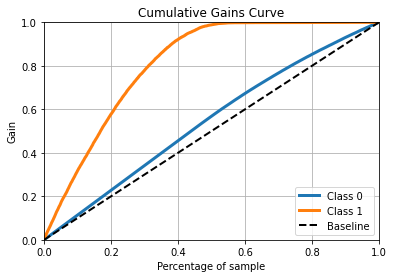

In [27]:
for i in range(final_result.shape[0]):
    j = final_result.loc[i, 'Iter_nr']
    param_dict = hyperparam_lst[j]
    
    # model
    model = xgb.XGBClassifier(objective='binary:logistic',
                              use_label_encoder=False,
                              n_estimators=param_dict['n_estimators'],
                              eta=param_dict['eta'],
                              gamma=param_dict['gamma'],
                              max_depth=param_dict['max_depth'],
                              n_jobs=-1,
                              subsample=param_dict['subsample'],
                              colsample_bytree=param_dict['colsample_bytree'],
                              min_child_weight=param_dict['min_child_weight'],
                              verbosity=0)
    
    # print results
    print(param_dict)
    xgb_ranking = model_evaluate(model, "XGBoost Classifier", df7_train, df7_validation, 20000)
    display(xgb_ranking)

All models perform very similarly. I will take the fourth one: {'n_estimators': 2000, 'eta': 0.01, 'gamma': 10, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}. The 4th (index=3) element in final_result (Iter_nr=2).

,Model name,precision_at_k,recall_at_k
0,XGBoost Classifier,0.333783,0.714622


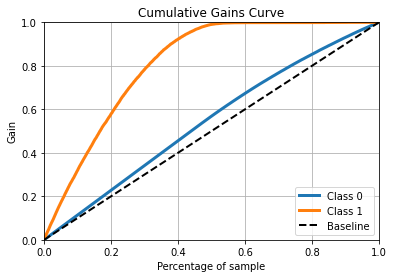

In [28]:
j = final_result.loc[3, 'Iter_nr']
param_dict = hyperparam_lst[j]
    
# model
model = xgb.XGBClassifier(objective='binary:logistic',
                          use_label_encoder=False,
                          n_estimators=param_dict['n_estimators'],
                          eta=param_dict['eta'],
                          gamma=param_dict['gamma'],
                          max_depth=param_dict['max_depth'],
                          n_jobs=-1,
                          subsample=param_dict['subsample'],
                          colsample_bytree=param_dict['colsample_bytree'],
                          min_child_weight=param_dict['min_child_weight'],
                          verbosity=0)

xgb_ranking = model_evaluate(model, "XGBoost Classifier", df7_train, df7_validation, 20000)
xgb_ranking

In [29]:
xgb_validated = model_fit(model, df7_train)

In [30]:
pickle.dump(xgb_validated, open(home_path + "ml_models_comp/xgb_validated_new_tree.pkl", "wb"))